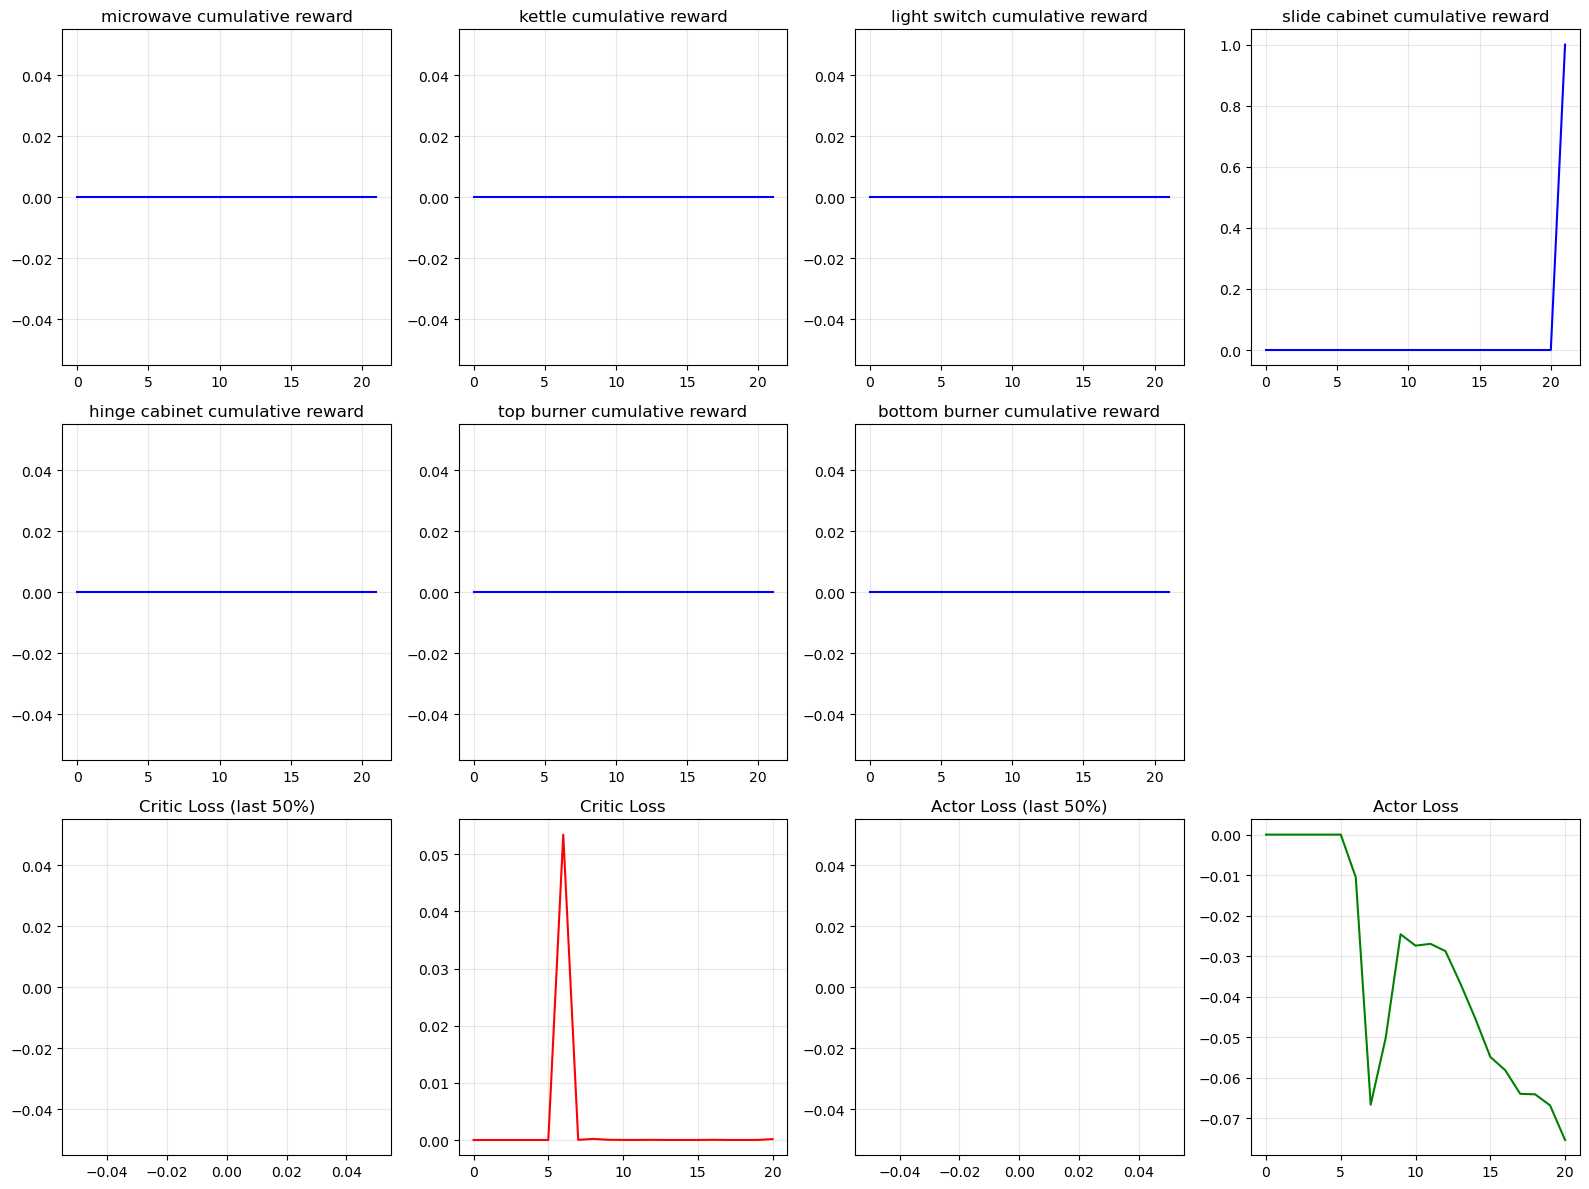

State Dim: 59, Goal Dim: 17, OHE Dim: 7
Running On Device: mps
Ep 0: Solved [] | Loss: 0 | Buffer: 300 | Unsolved: bottom burner
Ep 1: Solved [] | Loss: 0 | Buffer: 600 | Unsolved: microwave
Ep 2: Solved [] | Loss: 0 | Buffer: 900 | Unsolved: microwave
Ep 3: Solved [] | Loss: 0 | Buffer: 1200 | Unsolved: microwave
Ep 4: Solved [] | Loss: 0 | Buffer: 1500 | Unsolved: microwave
Ep 5: Solved [] | Loss: 0 | Buffer: 1800 | Unsolved: bottom burner
Ep 6: Solved [] | Loss: 0.05343 | Buffer: 2100 | Unsolved: hinge cabinet
Ep 7: Solved [] | Loss: 3e-05 | Buffer: 2400 | Unsolved: microwave
Ep 8: Solved [] | Loss: 0.00019 | Buffer: 2700 | Unsolved: bottom burner
Ep 9: Solved [] | Loss: 4e-05 | Buffer: 3000 | Unsolved: microwave
Ep 10: Solved [] | Loss: 1e-05 | Buffer: 3300 | Unsolved: slide cabinet
Ep 11: Solved [] | Loss: 1e-05 | Buffer: 3600 | Unsolved: bottom burner
Ep 12: Solved [] | Loss: 3e-05 | Buffer: 3900 | Unsolved: top burner
Ep 13: Solved [] | Loss: 1e-05 | Buffer: 4200 | Unsolved: hin

KeyboardInterrupt: 

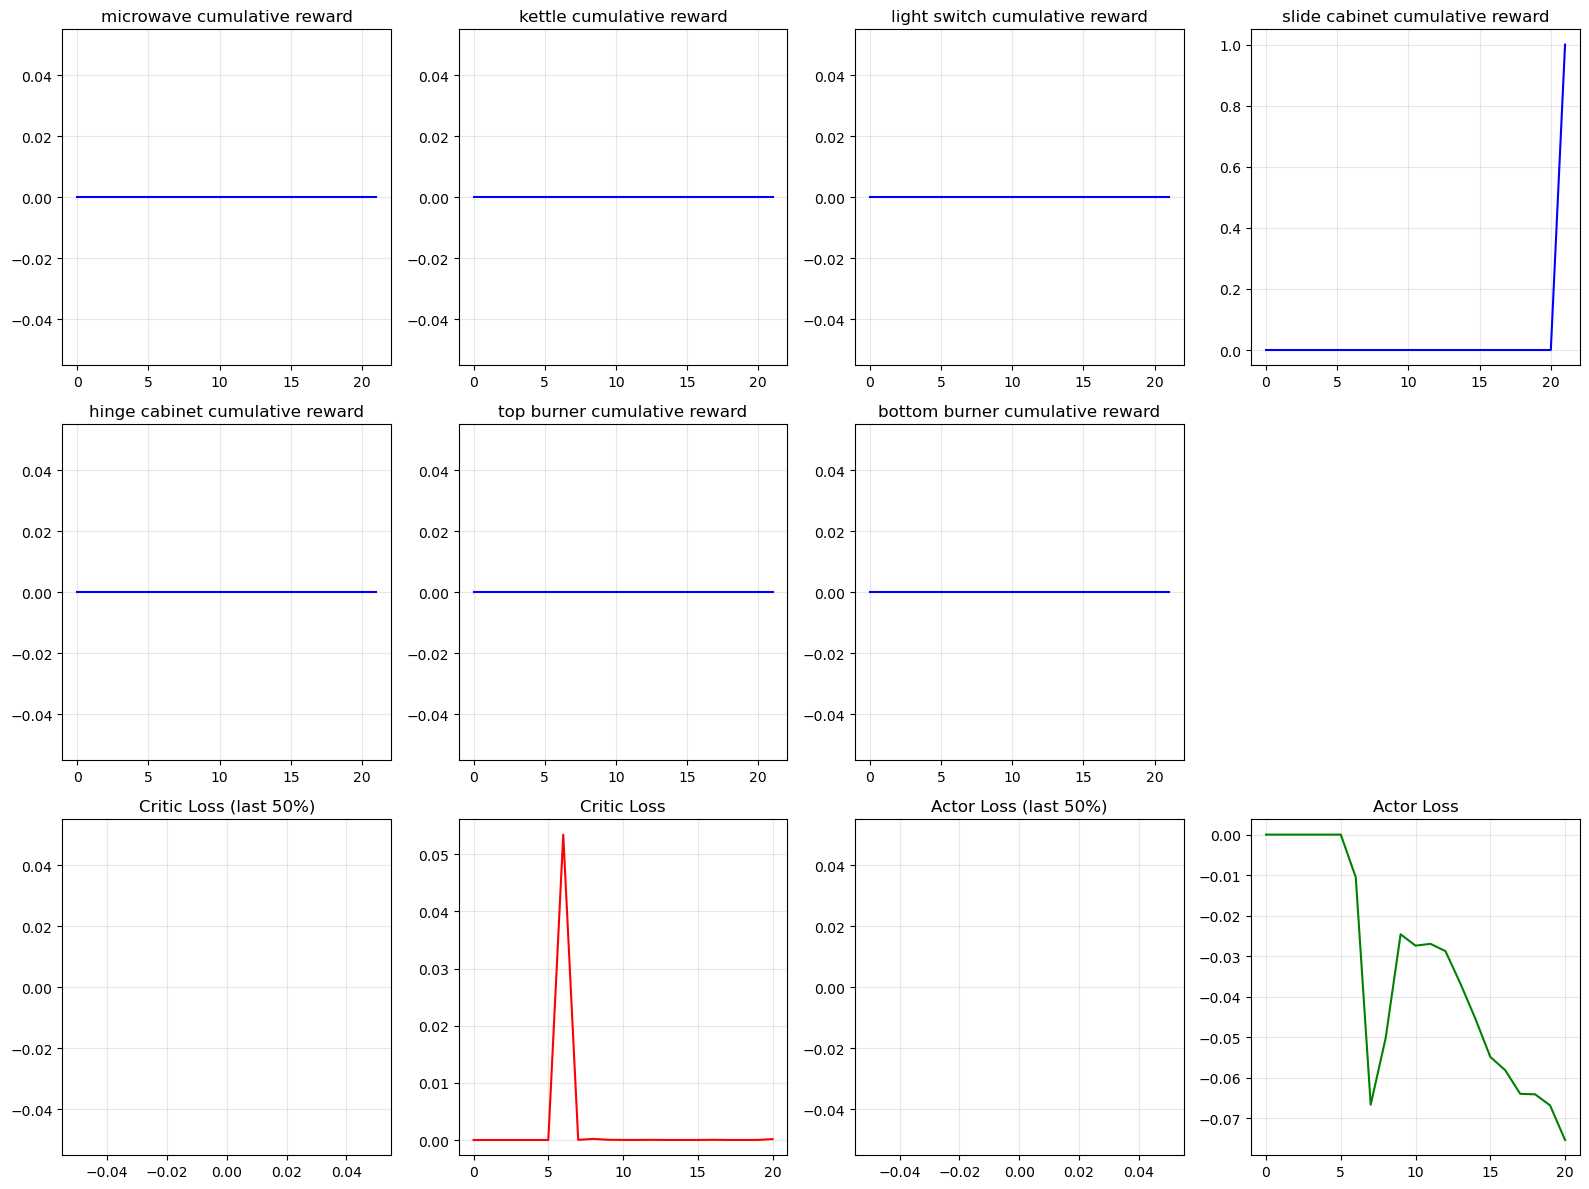

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gymnasium as gym
import gymnasium_robotics
import copy
import matplotlib.pyplot as plt
from IPython import display
import random
import os
from utils.functions import ohe_goals, flatten_info
from utils.agent import DDPGAgent
from utils.replay_buffer import ReplayBuffer

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False 

# --- CONFIGURATION ---
ENV_NAME = 'FrankaKitchen-v1' 
MAX_EPISODES = 20000
MAX_STEPS = 300
BATCH_SIZE = 256
START_TRAINING_AFTER = 2000
NOISE = 0.05
K = 2

# Saving & Plotting Config
CHECKPOINT_FREQ = 500
PLOT_FREQ = 20
RESUME_PATH = None 
CHECKPOINT_DIR = "checkpoints"

TASKS = ['microwave', 'kettle', 'light switch', 'slide cabinet', 'hinge cabinet', 'top burner', 'bottom burner']

if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

env = gym.make(ENV_NAME, max_episode_steps=MAX_STEPS, tasks_to_complete=TASKS)

obs_dict = env.reset()[0]
state_dim = obs_dict['observation'].shape[0]
action_dim = env.action_space.shape[0]
sample_goal = np.concatenate([obs_dict["desired_goal"][k] for k in TASKS])
goal_dim = sample_goal.shape[0]
ohe_dim = len(TASKS)

OHE_LOOKUP = ohe_goals(TASKS)
device = "mps"

replay_buffer = ReplayBuffer(state_dim, action_dim, ohe_dim, goal_dim, device)
agent = DDPGAgent(state_dim, action_dim, ohe_dim, goal_dim, device)


task_history = {task: [0] for task in TASKS}
cumulative_victories = {task: 0 for task in TASKS}

loss_history = {
    "critic_loss": [],
    "actor_loss": []
}

efficiency_history = {task: [] for task in TASKS}

start_episode = 0
total_steps = 0

plot_display = display.display(plt.figure(figsize=(16, 12)), display_id=True)

if RESUME_PATH is not None and os.path.exists(RESUME_PATH):
    print(f"Loading checkpoint: {RESUME_PATH}")
    checkpoint = torch.load(RESUME_PATH)
    
    agent.actor.load_state_dict(checkpoint["actor_state_dict"])
    agent.critic.load_state_dict(checkpoint["critic_state_dict"])
    agent.actor_optimizer.load_state_dict(checkpoint["actor_optimizer_state_dict"])
    agent.critic_optimizer.load_state_dict(checkpoint["critic_optimizer_state_dict"])
    
    task_history = checkpoint["task_history"]
    cumulative_victories = checkpoint["cumulative_reward"]

    loss_history = checkpoint.get("loss_history", loss_history)
    efficiency_history = checkpoint.get("efficiency_history", efficiency_history)
    
    total_steps = checkpoint["total_steps"]
    start_episode = checkpoint["episode"] + 1
    print(f"Resumed successfully from Episode {start_episode}")

print(f"State Dim: {state_dim}, Goal Dim: {goal_dim}, OHE Dim: {ohe_dim}")
print(f"Running On Device: {device}")


for episode in range(start_episode, MAX_EPISODES):
    
    raw_state, _ = env.reset()
    state, achieved_goal, desired_goal = flatten_info(raw_state, TASKS)
    
    episode_cache = []
    victory_map = {}
    current_start_index = 0
    undone_tasks = list(TASKS)

    ep_critic_losses = []
    ep_actor_losses = []
    
    current_task_name = np.random.choice(undone_tasks)
    current_ohe = OHE_LOOKUP[current_task_name]
    
    for step in range(MAX_STEPS):
        
        action = agent.select_action(state, current_ohe, desired_goal, noise=NOISE)
        next_raw_state, reward, terminated, truncated, info = env.step(action)
        next_state, next_achieved, next_desired = flatten_info(next_raw_state, TASKS)
        
        episode_cache.append({
            'state': state,
            'action': action,
            'next_state': next_state,
            'achieved_goal': next_achieved, 
            'desired_goal': next_desired,   
        })
        
        if info["step_task_completions"]:
            for task_name in info["step_task_completions"]:
                if task_name not in victory_map:
                    victory_map[task_name] = step
                    
                    duration = step - current_start_index
                    efficiency_history[task_name].append(duration)

                    solved_ohe = OHE_LOOKUP[task_name]
                    for i in range(current_start_index, step + 1):
                        data = episode_cache[i]
                        is_finish = (i == step)
                        replay_buffer.add(
                            data['state'], data['action'], solved_ohe,
                            data['desired_goal'], data['next_state'],
                            reward=1.0 if is_finish else 0.0,
                            done=1.0 if is_finish else 0.0
                        )
                    
                    current_start_index = step + 1
                    if task_name in undone_tasks: 
                        undone_tasks.remove(task_name)
                    
                    if undone_tasks:
                        current_task_name = np.random.choice(undone_tasks)
                        current_ohe = OHE_LOOKUP[current_task_name]

        state = next_state
        total_steps += 1
        
        # Train Agent
        if total_steps > START_TRAINING_AFTER:
            for _ in range(K):
                c_loss, a_loss = agent.train(replay_buffer, BATCH_SIZE)
                ep_critic_losses.append(c_loss)
                ep_actor_losses.append(a_loss)

        if terminated or truncated:
            break

    if current_start_index < len(episode_cache):
        for i in range(current_start_index, len(episode_cache)):
            data = episode_cache[i]
            replay_buffer.add(
                data['state'], 
                data['action'], 
                current_ohe,
                data['desired_goal'],
                data['next_state'],
                reward=0.0,
                done=0.0
            )

    for task in TASKS:
        if task in victory_map:
            cumulative_victories[task] += 1
        task_history[task].append(cumulative_victories[task])
    

    if ep_critic_losses:
        loss_history["critic_loss"].append(np.mean(ep_critic_losses))
        loss_history["actor_loss"].append(np.mean(ep_actor_losses))
    else:
        loss_history["critic_loss"].append(0)
        loss_history["actor_loss"].append(0)

    if episode % PLOT_FREQ == 0:
        plt.clf()
        
        for i, task in enumerate(TASKS):
            plt.subplot(3, 4, i + 1) # 3 Rows, 4 Cols
            plt.plot(task_history[task], label="cumulative reward", color="blue")
            plt.title(f"{task} cumulative reward")
            plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 4, 9)
        plt.plot(loss_history["critic_loss"][int(MAX_EPISODES/2):], color="red")
        plt.title("Critic Loss (last 50%)")
        plt.grid(True, alpha=0.3)

        plt.subplot(3, 4, 10)
        plt.plot(loss_history["critic_loss"], color="red")
        plt.title("Critic Loss")
        plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 4, 11)
        plt.plot(loss_history["actor_loss"][int(MAX_EPISODES/2):], color="green")
        plt.title("Actor Loss (last 50%)")
        plt.grid(True, alpha=0.3)

        plt.subplot(3, 4, 12)
        plt.plot(loss_history["actor_loss"], color="green")
        plt.title("Actor Loss")
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plot_display.update(plt.gcf())

    if (episode + 1) % CHECKPOINT_FREQ == 0:
        checkpoint_data = {
            "episode": episode,
            "actor_state_dict": agent.actor.state_dict(),
            "critic_state_dict": agent.critic.state_dict(),
            "actor_optimizer_state_dict": agent.actor_optimizer.state_dict(),
            "critic_optimizer_state_dict": agent.critic_optimizer.state_dict(),
            "task_history": task_history,
            "cumulative_reward": cumulative_victories, 
            "loss_history": loss_history,
            "efficiency_history": efficiency_history,
            "total_steps": total_steps,
        }
        save_filename = f"{CHECKPOINT_DIR}/checkpoint_{episode + 1}.pth"
        torch.save(checkpoint_data, save_filename)
        print(f"--> Checkpoint saved: {save_filename}")

    c_loss_print = round(loss_history["critic_loss"][-1], 5) if loss_history["critic_loss"] else 0
    print(f"Ep {episode}: Solved {list(victory_map.keys())} | Loss: {c_loss_print} | Buffer: {replay_buffer.size} | Unsolved: {current_task_name}")